In [ ]:
from google.colab import drive
import os
import gdown # Library to download files from Google Drive
!gdown 1ba77UQl24FgekMX58BrNtba_zcFAo1Dv # Google Drive ID of the zip file to be downloaded


Downloading...
From (original): https://drive.google.com/uc?id=1ba77UQl24FgekMX58BrNtba_zcFAo1Dv
From (redirected): https://drive.google.com/uc?id=1ba77UQl24FgekMX58BrNtba_zcFAo1Dv&confirm=t&uuid=51627ecd-4e50-44eb-9e0b-f1a267f89fa9
To: /content/images.zip
100% 273M/273M [00:03<00:00, 86.0MB/s]


In [ ]:
!unzip -oq images # Unzip the file downloaded. Options -o and -q overwrites the files if exists already and disables printing out the extracted files, respectively.

In [ ]:

root_dir = '/content/images'


In [ ]:
import gdown

# Define the Google Drive file ID for the responses.json file
file_id = '17yEXHnf1Q7KAJyqvIOFzFWNg1nh0oJhc'

# Define the output path for the downloaded file
output_path = '/content/ad_responses.json'

# Download the file using gdown
gdown.download(f'https://drive.google.com/uc?id={file_id}', output_path, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=17yEXHnf1Q7KAJyqvIOFzFWNg1nh0oJhc
To: /content/ad_responses.json
100%|██████████| 23.1M/23.1M [00:00<00:00, 112MB/s] 


'/content/ad_responses.json'

In [16]:
import json
import os
from PIL import Image
import numpy as np
import pickle

# Load the JSON data
responses_file = '/content/ad_responses.json'
with open(responses_file, 'r') as f:
    data = json.load(f)

# Create a dictionary to map '_id' to ad_info for faster lookup
ad_info_dict = {info['_id']: info for info in data.values() if '_id' in info}
# Define the root directory for images
images_dir = '/content/images'

# Define the target dimensions for resizing images (lower resolution for efficiency)
target_width = 512   # Lower resolution
target_height = 512  # Lower resolution

# Initialize lists to store calculated and extracted features
campaign_data = []

# Define the function to calculate age group percentages
def calculate_age_group(demographics):
    age_groups = {
        'age-13-17': 0,
        'age-18-24': 0,
        'age-25-34': 0,
        'age-35-44': 0,
        'age-45-54': 0,
        'age-55-64': 0,
        'age-65+': 0
    }
    for demo in demographics:
        age = demo['age']
        percentage = float(demo['percentage'])
        if age == '18-24':
            age_groups['age-18-24'] += percentage
        elif age == '25-34':
            age_groups['age-25-34'] += percentage
        elif age == '35-44':
            age_groups['age-35-44'] += percentage
        elif age == '45-54':
            age_groups['age-45-54'] += percentage
        elif age == '55-64':
            age_groups['age-55-64'] += percentage
        elif age == '65+':
            age_groups['age-65+'] += percentage
        else:
            age_groups['age-13-17'] += percentage  # Assuming all other ages fall into this category
    return age_groups

# Iterate through each image in the images directory
for filename in os.listdir(images_dir):
    if filename.endswith(".jpg"):  # Check if the file is a JPEG image
        image_id = filename.split('.')[0]  # Extract ID from filename
        for key, value in ad_info_dict.items():
            if '_id' in value and value['_id'] == image_id:
                ad_info = value
                image_path = os.path.join(images_dir, filename)

                # Load and preprocess the image
                with Image.open(image_path) as img:
                    img = img.convert('RGB')  # Convert image to RGB format
                    img = img.resize((target_width, target_height))  # Resize image to lower resolution
                    img_array = np.array(img)  # Convert image to numpy array

                # Process only the necessary data to reduce memory load
                avg_spend = np.mean([int(ad_info.get("spend", {}).get("lower_bound", 0)), int(ad_info.get("spend", {}).get("upper_bound", 0))])
                avg_impressions = np.mean([int(ad_info.get("impressions", {}).get("lower_bound", 0)), int(ad_info.get("impressions", {}).get("upper_bound", 0))])
                cost_per_impression = avg_spend / avg_impressions if avg_impressions > 0 else float('inf')

                # Calculate age group percentages
                age_groups = calculate_age_group(ad_info.get('demographic_distribution', []))

                # Append only necessary info to reduce memory footprint
                campaign_data.append({
                    "ad_id": ad_info.get('_id', ''),
                    "cpi": cost_per_impression,
                    "image_data": img_array.flatten().tolist(),  # Flatten and convert to list to minimize size
                    "age_groups": age_groups
                })
                break

# Save the normalized data
with open('/content/campaign_data.pkl', 'wb') as f:
    pickle.dump(campaign_data, f)

# Clear the large variables from memory
del campaign_data
del data


In [5]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_filenames, labels_cpi, labels_age_groups, image_directory, batch_size):
        self.image_filenames = image_filenames  # This should be a list of IDs
        self.labels_cpi = labels_cpi  # This should be a dictionary {id: cpi}
        self.labels_age_groups = labels_age_groups  # This should be a dictionary {id: age_group_index}
        self.image_directory = image_directory
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, idx):
      batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
      batch_y_cpi = [self.labels_cpi[x] for x in batch_x if x in self.labels_cpi]
      batch_y_age_groups = [to_categorical(self.labels_age_groups[x], num_classes=7) for x in batch_x if x in self.labels_age_groups]

      images = []
      for file_id in batch_x:
          file_path = os.path.join(self.image_directory, f'{file_id}.jpg')
          if os.path.exists(file_path):
              img = Image.open(file_path)
              img = img.resize((512, 512), Image.ANTIALIAS)  # Using ANTIALIAS for better resizing quality
              img_array = np.array(img) / 255.0  # Normalize the images
              if img_array.shape != (512, 512, 3):  # Ensure each image has the correct shape
                  print(f"Debug: Incorrect image shape {img_array.shape} for file: {file_path}")
                  img_array = np.zeros((512, 512, 3))  # Correct the shape with a zero array
              images.append(img_array)
          else:
              print(f"Debug: File not found, using zero array for: {file_path}")
              images.append(np.zeros((512, 512, 3)))  # Ensure the shape matches expected input dimensions

      images = np.stack(images)  # Ensures all images are the same shape
      batch_y_cpi = np.array(batch_y_cpi, dtype=np.float32)

      if batch_y_age_groups:  # Check if list is not empty before stacking
          batch_y_age_groups = np.stack(batch_y_age_groups)
      else:
          print("Debug: No age group data available for this batch.")
          batch_y_age_groups = np.zeros((len(batch_x), 7))  # Create a placeholder with zeros

      print("Images array shape after conversion:", images.shape)
      print("CPI labels shape after conversion:", batch_y_cpi.shape)
      print("Age groups shape after conversion:", batch_y_age_groups.shape)

      return images, [batch_y_cpi, batch_y_age_groups]



    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, image_filenames_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=float)

        # Generate data
        for i, image_filename in enumerate(image_filenames_temp):
            # Store sample
            img = load_img(os.path.join(self.image_directory, image_filename + '.jpg'), target_size=self.dim)
            X[i,] = img_to_array(img) / 255.0

            # Store class
            y[i] = self.labels[image_filename]

        return X, y


In [2]:
import pickle

# Load the processed data from disk
with open('/content/campaign_data.pkl', 'rb') as f:
    campaign_data = pickle.load(f)

# Print the first few entries of the campaign data to verify
for campaign in campaign_data[:3]:  # Adjust the range as needed for more samples
    print("Ad ID:", campaign["ad_id"])
    print("Cost Per Impression (CPI):", campaign["cpi"])
    print("Sample Image Data (flattened):", campaign["image_data"][:10])  # Show only the first 10 pixels to keep output manageable
    print("Age Group Percentages:")
    for age_group, percentage in campaign["age_groups"].items():
        print(f"{age_group}: {percentage:.2%}")
    print("\n")


Ad ID: 401171250412601
Cost Per Impression (CPI): 0.003089096525630047
Sample Image Data (flattened): [105, 90, 83, 106, 91, 84, 107, 92, 85, 107]
Age Group Percentages:
age-13-17: 0.00%
age-18-24: 15.72%
age-25-34: 24.87%
age-35-44: 19.55%
age-45-54: 16.11%
age-55-64: 13.81%
age-65+: 9.95%


Ad ID: 1446433942154722
Cost Per Impression (CPI): 0.01315270080368844
Sample Image Data (flattened): [175, 184, 199, 175, 184, 199, 175, 184, 199, 177]
Age Group Percentages:
age-13-17: 0.00%
age-18-24: 6.28%
age-25-34: 13.53%
age-35-44: 20.36%
age-45-54: 23.23%
age-55-64: 22.72%
age-65+: 13.88%


Ad ID: 2115518362093406
Cost Per Impression (CPI): 0.017320230936412485
Sample Image Data (flattened): [238, 238, 238, 238, 238, 238, 238, 238, 238, 238]
Age Group Percentages:
age-13-17: 0.00%
age-18-24: 3.99%
age-25-34: 29.99%
age-35-44: 28.30%
age-45-54: 16.98%
age-55-64: 11.25%
age-65+: 9.48%




In [1]:
import tensorflow as tf

# Check TensorFlow GPU usage
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow will run on GPU")
else:
    print("TensorFlow will run on CPU")

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


Num GPUs Available:  0
TensorFlow will run on CPU


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from PIL import Image

labels_cpi = {item['ad_id']: item['cpi'] for item in campaign_data}
labels_age_groups = {item['ad_id']: list(item['age_groups'].values()) for item in campaign_data}  # Ensure this mapping is correct

image_filenames = [item['ad_id'] for item in campaign_data]  # IDs should match exactly in labels

# Splitting the dataset
image_filenames_train, image_filenames_test, labels_cpi_train, labels_cpi_test, labels_age_groups_train, labels_age_groups_test = train_test_split(
    image_filenames, [labels_cpi[id] for id in image_filenames], [labels_age_groups[id] for id in image_filenames], test_size=0.2, random_state=42)

# Create the generator for CPI
batch_size = 10  # Depends on your available memory
# Example instantiation and model fitting
train_generator = DataGenerator(image_filenames_train, labels_cpi_train, labels_age_groups_train, '/content/images', batch_size)
test_generator = DataGenerator(image_filenames_test, labels_cpi_test, labels_age_groups_test, '/content/images', batch_size)

# Define your model's input shape based on the data dimensions you will train on
input_shape = (512, 512, 3)  # Modify according to your resized image dimensions

# Define the model for CPI prediction
model_cpi = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='linear', name='cpi_output')  # Linear activation for regression
])

# Compile the model for CPI prediction
model_cpi.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_squared_error'])

# Define the model for age distribution prediction
model_age_groups = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(7, activation='softmax', name='age_output')  # Softmax activation for classification
])

# Compile the model for age distribution prediction
model_age_groups.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Combine both models into a single model
combined_model_input = tf.keras.Input(shape=input_shape)
cpi_output = model_cpi(combined_model_input)
age_output = model_age_groups(combined_model_input)

combined_model = Model(inputs=combined_model_input, outputs=[cpi_output, age_output])

# Compile the combined model with appropriate loss functions and metrics
combined_model.compile(optimizer='adam', loss=['mean_absolute_error', 'categorical_crossentropy'], metrics=['mean_squared_error', 'accuracy'])

# Show the model structure
combined_model.summary()

# Now use this combined model with both generators directly in model.fit

combined_model.fit(train_generator, epochs=10, validation_data=test_generator)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 sequential_2 (Sequential)   (None, 1)                    1300758   ['input_2[0][0]']             
                                                          41                                      
                                                                                                  
 sequential_3 (Sequential)   (None, 7)                    1300766   ['input_2[0][0]']             
                                                          15                                      
                                                                                            

<ipython-input-5-091371c96b51>:28: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((512, 512), Image.ANTIALIAS)  # Using ANTIALIAS for better resizing quality


Debug: Incorrect image shape (512, 512, 4) for file: /content/images/1907063079596864.jpg
Debug: No age group data available for this batch.
Images array shape after conversion: (10, 512, 512, 3)
CPI labels shape after conversion: (0,)
Age groups shape after conversion: (10, 7)
Epoch 1/10


In [ ]:
#abs - squared error
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Mean Absolute Error (MAE): {test_mae}")

24/24 [==============================] - 5s 193ms/step - loss: 0.0160 - mean_squared_error: 6.6541e-04
Test Loss: 0.016047503799200058
Mean Absolute Error (MAE): 0.0006654096068814397


In [ ]:
#squared error - abs error
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Mean Absolute Error (MAE): {test_mae}")



12/12 [==============================] - 2s 164ms/step - loss: 0.0280 - mean_squared_error: 0.0024
Test Loss: 0.028036927804350853
Mean Absolute Error (MAE): 0.0024414174258708954


In [ ]:
test_cpis = []
for batch_images, batch_labels in test_generator:
    test_cpis.extend(batch_labels)  # Assuming batch_images contains the image filenames, which are the IDs

# Now test_ids contains all the IDs in the test generator
print("CPIs in the test generator:", test_cpis)


CPIs in the test generator: [0.0024422276493947766, 0.023332682221788147, 0.014705302767825158, 0.007775572834606299, 0.01425755021572045, 0.019934662310820722, 0.009998957893639889, 0.05545060562284698, 0.011997365326307536, 0.013843119517290822, 0.0033320044426725904, 0.007615970459266097, 0.06355123193017546, 0.09969989996665556, 0.01425755021572045, 0.019971999199977143, 0.01980396079215843, 0.0990990990990991, 0.017589269957056296, 0.009997799995111101, 0.008440037511277828, 0.011809198265438777, 0.03322591399044338, 0.009998199996727266, 0.09969989996665556, 0.00908730577202099, 0.149999, 0.04396175847033881, 0.0057842409696893145, 0.033011003667889297, 0.06469487876327956, 0.009072892234404262, 0.0598119623924785, 0.006921549110075554, 0.016345751740940745, 0.005210800568450971, 0.01999849230537278, 0.03683196665228055, 0.015551180227467678, 0.011960478419136765, 0.06537742598019984, 0.0598119623924785, 0.019934662310820722, 0.00900081825620511, 0.0646508618154009, 0.01100122235

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras.models import load_model

# Assuming 'model' and 'test_generator' are defined and loaded appropriately
# Load your model if it is not already loaded
# model = load_model('path_to_your_model.h5')

# Extract labels and predictions without assuming reset functionality
test_cpis = []
predictions = []
for batch_images, batch_labels in test_generator:
    test_cpis.extend(batch_labels)
    predictions.extend(model.predict_on_batch(batch_images))

# Convert data to numpy arrays for easier manipulation
test_cpis = np.array(test_cpis)
predictions = np.array(predictions)

# Initialize accuracy counts for each order position
num_trials = 500
accuracy_counts = np.zeros(4)

# Print lengths to verify data sizes
print("Predicted data length:", len(predictions))
print("Actual data length:", len(test_cpis))

# Validate if we have enough elements to randomly pick 4
if len(predictions) >= 4 and len(test_cpis) >= 4:
    for _ in range(num_trials):
        # Randomly pick 4 indices ensuring no out of bound error
        indices = np.arange(min(len(predictions), len(test_cpis)))
        selected_indices = shuffle(indices)[:4]  # No fixed seed for true randomness each trial

        # Extract selected predictions and actual values
        selected_predictions = predictions[selected_indices]
        selected_actuals = test_cpis[selected_indices]

        # Order by predictions
        order_pred_indices = np.argsort(selected_predictions[:, 0])  # Assuming predictions are in the first column
        order_actual_indices = np.argsort(selected_actuals)

        # Compare orders
        accuracy_positions = [1 if pred_i == act_i else 0 for pred_i, act_i in zip(order_pred_indices, order_actual_indices)]
        accuracy_counts += accuracy_positions

    # Calculate average accuracies for each order
    average_accuracies = accuracy_counts / num_trials
    print("Average Accuracy at first position:", average_accuracies[0])
    print("Average Accuracy at second position:", average_accuracies[1])
    print("Average Accuracy at third position:", average_accuracies[2])
    print("Average Accuracy at fourth position:", average_accuracies[3])
else:
    print("Not enough data points to select 4 unique values. Please ensure at least 4 data points are available.")


Predicted data length: 240
Actual data length: 240
Average Accuracy at first position: 0.354
Average Accuracy at second position: 0.278
Average Accuracy at third position: 0.274
Average Accuracy at fourth position: 0.318


In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score

# First, gather all predictions and actuals
y_true = []
y_pred = []
for batch_images, batch_labels in test_generator:
    preds = model.predict_on_batch(batch_images)
    y_pred.extend(preds)
    y_true.extend(batch_labels)

# Convert lists to numpy arrays for easier manipulation
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate the concordance index, treating it similar to AUC calculation
def calculate_concordance_index(y_true, y_pred):
    n = 0
    h_sum = 0
    for i in range(len(y_true)):
        for j in range(i + 1, len(y_true)):
            if y_true[i] != y_true[j]:
                n += 1
                if (y_pred[i] > y_pred[j] and y_true[i] > y_true[j]) or (y_pred[i] < y_pred[j] and y_true[i] < y_true[j]):
                    h_sum += 1
                elif y_pred[i] == y_pred[j]:
                    h_sum += 0.5
    return h_sum / n if n > 0 else 0

# Calculate the C-index
c_index = calculate_concordance_index(y_true, y_pred)
print("Concordance Index:", c_index)


Concordance Index: 0.5634373019784552


24/24 [==============================] - 4s 159ms/step
[0.01753137]
0.04581253201964348
[0.03685854]
0.035091358243902145
[0.03686155]
0.019425027160813655
[0.03512993]
0.023563622836356286
[0.03504461]
0.034026999709255636
[0.0525687]
0.08869409321693661
[0.02866]
0.07770218072903522
[0.04326495]
0.1154099091960989
[0.033433]
0.014140393112971727
[0.03369978]
0.08869409321693661
[0.03082199]
0.03898425183181553
[0.03534913]
0.011570060642888829


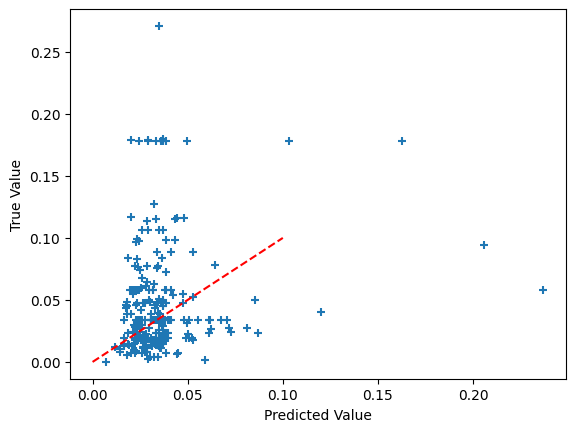

In [ ]:
#abs error - squared error

import matplotlib.pyplot as plt

test_predict = model.predict(test_generator)
count = 0
for i in range (0,12):
  print(test_predict[i])
  print(test_cpis[i])
# Create the scatter plot
plt.figure()
plt.scatter(test_predict, test_cpis, marker="+")
plt.xlabel("Predicted Value")
plt.ylabel("True Value")

# Add a reference line
plt.plot([0, 0.1], [0, 0.1], "r--")  # Assuming the range of values is -60 to 60, adjust as needed

# Show the plot
plt.show()

In [ ]:
from google.colab import drive
import shutil
# Mount Google Drive
shutil.rmtree('/content/drive', ignore_errors=True)
drive.mount('/content/drive')
# Save the model to Google Drive
model.save('/content/drive/MyDrive/path/to/save/model.h5')

Mounted at /content/drive
